# All Data EDA

Description of data cleaning before this file:

1. Load, combine, clean credit rating datasets to get unique ratings, company/tickers, and rating issue dates (unique key is credit rating, rating agency, and issuance date). Limit to S&P ratings from 2010-2016.
2. Load and clean dataset of earnings call transcripts, dates, year + quarter of statement releases, companies (unique key is company by earnings call date).
3. Load and clean tabular financial statement datasets (unique key is company, year, quarter).
4. Load and clean company sector dataset (unique key is company).
5. Use earnings call dates to transform dataset of credit ratings so there is one rating at each fixed quarter date (1/1, 4/1, 7/1, 10/1) for each year. The key assumption is that a rating stays the same until a new rating is issued.
6. Inner join earnings call data with credit rating data, retrieving the most recent earnings call. Use year and quarter from earnings calls to inner join with financial statement data. This produces the `all_data_fixed_quarter` dataset.

GitHub copilot suggestions were used for plotting and low-level syntax.

## Setup - Sample Path and Packages

In [1]:
# Flag for if you are running this on the sample dataset
# Sample comprises 100 earnings calls (transcripts included)
# Full data comprises ??? earnings calls (transcripts included)
sample = False
# Modify this path as needed to run on your machine
sample_path = r'~\Box\STAT 222 Capstone\Intermediate Data\All_Data\all_data_fixed_quarter_dates_sample.csv'

In [2]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stattotex import *

In [3]:
# Set output folder
output_folder = '../../../Output/All Data EDA/Tabular EDA/'

## Load Variable Index for Variable Name Formatting

In [4]:
# Load Variable Index
var_index = pd.read_excel('../../../Variable Index.xlsx')
# Create dictionary mapping column_name to Clean Column Name
var_index_dict = dict(zip(var_index['column_name'], var_index['Clean Column Name']))
var_index_dict

{'Altman_Z': "Altman's Z Score",
 'EBIT': 'EBIT',
 'common_plus_preferred_stock': 'Common Plus Preferred Stock',
 'workingCapital': 'Working Capital',
 'Ratio_A': 'Ratio A',
 'Ratio_B': 'Ratio B',
 'Ratio_C': 'Ratio C',
 'Ratio_D': 'Ratio D',
 'Ratio_E': 'Ratio E',
 'Positiv': 'Positive Tone',
 'Negativ': 'Negative Tone',
 'Strong': 'Strong Tone',
 'Weak': 'Weak Tone',
 'Active': 'Active Tone',
 'Passive': 'Passive Tone',
 'Ovrst': 'Overstated Tone',
 'Undrst': 'Understated Tone',
 'PN': 'Postivity-Negativity Tone Score',
 'SW': 'Strong-Weak Tone Score',
 'AP': 'Active-Passive Tone Score',
 'OU': 'Overstated-Understated Tone Score',
 'rating_date': 'Rating Date',
 'Next Rating': 'Next Rating',
 'Next Rating Date': 'Next Rating Date',
 'next_rating_date_or_end_of_data': 'Next Rating Date or End of Data',
 'credit_rating_year': 'Credit Rating Year',
 'days_since_rating': 'Days Since Rating',
 'Previous Rating': 'Previous Rating',
 'Previous Rating Date': 'Previous Rating Date',
 'reporte

## Data Load and Basic Stats

In [5]:
# Load in sample csv, or full parquet file
# Use sample or full data path
if sample:
    df = pd.read_csv(sample_path)
else:
    # Limit to items in the finalized dataset
    # list of files in '../../../Data/All_Data/All_Data_with_NLP_Features'
    import os
    file_list = [f for f in os.listdir(r'../../../Data/All_Data/All_Data_with_NLP_Features') if f.endswith('.parquet')]
    # read in all parquet files
    df = pd.concat([pd.read_parquet(r'../../../Data/All_Data/All_Data_with_NLP_Features/' + f) for f in file_list])
df

,ticker,fixed_quarter_date,earnings_call_date,Rating,rating_date,Next Rating,Next Rating Date,Previous Rating,Previous Rating Date,next_rating_date_or_end_of_data,...,Passive,Ovrst,Undrst,PN,SW,AP,OU,tone,num_q_by_len,train_test_80_20
0,AAPL,2014-10-01,2014-07-22,AA,2014-05-27,AA,2015-02-18,AAA,2014-04-24,2015-02-18,...,186.0,364.0,131.0,5.518519,15.261905,2.661290,2.778626,3.188264,0.003822,train
1,AAPL,2015-01-01,2014-10-20,AA,2014-05-27,AA,2015-02-18,AAA,2014-04-24,2015-02-18,...,199.0,465.0,152.0,5.348485,15.934783,3.296482,3.059211,3.681858,0.002766,train
2,AAPL,2015-04-01,2015-01-27,AA,2015-02-18,AA,2015-05-28,AA,2014-05-27,2015-05-28,...,208.0,468.0,151.0,3.927711,8.113636,2.841346,3.099338,1.307366,0.004628,train
3,AAPL,2015-07-01,2015-04-27,AA,2015-06-02,AA,2015-08-25,AA,2015-05-28,2015-08-25,...,214.0,415.0,135.0,5.250000,9.142857,2.640187,3.074074,2.025933,0.003861,train
4,AAPL,2015-10-01,2015-07-21,AA,2015-08-25,AA,2016-05-20,AA,2015-06-02,2016-05-20,...,219.0,449.0,148.0,4.209877,10.442857,2.579909,3.033784,1.815531,0.003915,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,MHO,2013-10-01,2013-07-25,CC,2013-05-07,CC,2013-11-06,CCC,2012-11-29,2013-11-06,...,122.0,180.0,82.0,7.153846,10.225000,2.418033,2.195122,2.140598,0.002420,train
547,MHO,2014-01-01,2013-10-24,CC,2013-11-06,CCC,2014-07-31,CC,2013-05-07,2014-07-31,...,152.0,294.0,166.0,4.516129,6.771084,3.039474,1.771084,-0.029287,0.003039,train
548,MHO,2014-04-01,2014-01-29,CC,2013-11-06,CCC,2014-07-31,CC,2013-05-07,2014-07-31,...,136.0,325.0,158.0,3.835821,7.078947,3.264706,2.056962,0.084888,0.002848,test
549,MHO,2014-07-01,2014-04-24,CC,2013-11-06,CCC,2014-07-31,CC,2013-05-07,2014-07-31,...,127.0,194.0,103.0,3.703704,6.944444,2.590551,1.883495,-0.319794,0.001551,test


In [6]:
## summary of the raw data 

# column cleanup - if 'readability' is in the dataframe, drop it
if 'readability' in df.columns:
    df = df.drop(columns='readability')

# Summarize all numeric columns
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
# pandas setting to display all rows
pd.set_option('display.max_rows', None)
sum_stats = df.describe().T
sum_stats

,count,mean,min,25%,50%,75%,max,std
credit_rating_year,"5,509.00","2,013.32","2,010.00","2,012.00","2,013.00","2,015.00","2,016.00",1.56
days_since_call_on_fixed_quarter,"5,509.00",58.39,0.00,55.00,61.00,66.00,91.00,13.05
days_since_rating,"5,509.00",345.66,0.00,96.00,205.00,410.00,"2,314.00",392.07
for_quarter,"5,509.00",2.46,1.00,1.00,2.00,3.00,4.00,1.11
for_year,"5,509.00","2,013.97","2,010.00","2,013.00","2,014.00","2,015.00","2,017.00",1.47
cashAndCashEquivalents,"5,509.00","862,135,865.07",0.00,"93,424,000.00","333,000,000.00","960,000,000.00","9,223,000,000.00","1,366,595,243.17"
shortTermInvestments,"5,509.00","182,988,242.55","-515,000.00",0.00,0.00,"17,975,000.00","6,178,000,000.00","599,747,024.65"
cashAndShortTermInvestments,"5,509.00","1,060,086,810.64",0.00,"94,040,000.00","363,008,000.00","1,134,987,000.00","15,601,000,000.00","1,890,682,420.93"
netReceivables,"5,509.00","1,276,905,848.63","-4,199,600.00","225,600,000.00","570,338,000.00","1,449,000,000.00","12,116,000,000.00","1,776,578,353.43"
inventory_balance_sheet,"5,509.00","933,043,177.40","-19,626,000.00","103,620,000.00","403,789,000.00","1,130,000,000.00","8,328,000,000.00","1,398,934,358.21"


In [7]:
# Revert to default settings
pd.reset_option('display.float_format')
pd.reset_option('display.max_rows')

In [8]:
# Clean up sum_stats and export to Excel and LaTeX
# reset index and rename to 'Variable Name', keep columns 'mean', 'min', '50%', 'max', 'std' and rename those variables
# values of 'Variable Name' to remove - 'earnings_call_date', 'credit_rating_year', 'for_quarter', 'for_year', 'financial_statement_date'
# use dictionary mapping column_name to Clean Column Name to edit values of 'Variable Name'
# merge on 'Variable Type' from the Variable Index df
# drop cases where 'Variable Type' string contains 'Constructed' or 'Disallowed'
# sort by 'Variable Type' and 'Variable Name'
sum_stats_clean = (sum_stats.reset_index()[['index', 'mean', 'min', '50%', 'max', 'std']]
                            .rename(columns={'index': 'Variable Name', 'mean': 'Mean', 'min': 'Minimum', '50%': 'Median', 'max': 'Maximum', 'std': 'Standard Deviation'})
                            .query('`Variable Name` not in ["earnings_call_date", "credit_rating_year", "for_quarter", "for_year", "financial_statement_date"]')
                            .replace({'Variable Name': var_index_dict})
                            .merge(var_index[['Clean Column Name', 'Variable Type']], left_on='Variable Name', right_on='Clean Column Name')
                            .drop(columns='Clean Column Name')
                            #.query("not `Variable Type`.str.contains('Constructed') and not `Variable Type`.str.contains('Disallowed')", engine="python")
                            .query("not `Variable Type`.str.contains('Disallowed')", engine="python")
                            .sort_values(['Variable Type', 'Variable Name']))

# Export to Excel
sum_stats_clean.to_excel(output_folder + 'Numeric_Summary_Statistics.xlsx', index=False)

# Export to LaTeX
# Center all columns
# Two decimal places for all variables and commas for thousands
#sum_stats_clean.set_index('Variable Name').style.format(decimal='.', thousands=',', precision=2).to_latex(output_folder + 'Numeric_Summary_Statistics.tex', column_format='l' + 'c' * 6, hrules=True)
# Format numbers by converting to formatted strings
for col in ['Mean', 'Minimum', 'Median', 'Maximum', 'Standard Deviation']:
    sum_stats_clean[col] = sum_stats_clean[col].apply(lambda x: '{:,.2f}'.format(x))
# Export to LaTeX
lt_string = sum_stats_clean.to_latex(index=False, column_format='c' * 7, escape=False, longtable=True, label='tab:numeric_summary_statistics', caption='Numeric Summary Statistics')
latex_with_font_size = "\\tiny\n" + lt_string + "\n\\normalsize"
with open(output_folder + 'Numeric_Summary_Statistics.tex', 'w') as f:
    f.write(latex_with_font_size)

sum_stats_clean

,Variable Name,Mean,Minimum,Median,Maximum,Standard Deviation,Variable Type
157,Difference in Cash Per Share from prior fixed ...,-0.01,-69.19,0.00,69.02,4.54,Additional Change Ratios
145,Difference in Cash Ratio from prior fixed quarter,0.05,-53.11,0.00,53.11,3.98,Additional Change Ratios
151,Difference in Debt Ratio (Alternative) from pr...,0.00,-0.76,0.00,0.78,0.05,Additional Change Ratios
150,Difference in Debt Ratio from prior fixed quarter,0.00,-0.82,0.00,0.83,0.05,Additional Change Ratios
152,Difference in Debt to Equity Ratio from prior ...,-1.90,"-1,915.81",0.00,"1,892.37",113.71,Additional Change Ratios
...,...,...,...,...,...,...,...
164,Number of Questions,36.50,0.00,35.00,107.00,16.38,NLP Feature
178,Number of Questions Divided By Call Word Count,0.00,0.00,0.00,0.01,0.00,NLP Feature
161,Numeric Transparency,0.12,0.01,0.12,0.40,0.05,NLP Feature
163,Word Count,"8,834.15",525.00,"9,083.00","22,006.00","2,471.87",NLP Feature


In [9]:
# Version that includes just the financial variables
# Filter to just financial variables
financial_vars = var_index[var_index['Rating Model 2'] == 'X']
print(financial_vars.columns)
#print(list(financial_statement_vars['column_name']))
# Keep only Variable Name and inner join with sum_stats_clean
sum_stats_clean_financial = sum_stats_clean.merge(financial_vars[['Clean Column Name']], left_on='Variable Name', right_on='Clean Column Name').drop(columns='Clean Column Name').sort_values(['Variable Type', 'Variable Name'])

# Export to Excel
sum_stats_clean_financial.to_excel(output_folder + 'Financial_Summary_Statistics.xlsx', index=False)

# Export to LaTeX
lt_string = sum_stats_clean_financial.to_latex(index=False, column_format='c' * 7, escape=False, longtable=True, label='tab:financial_summary_statistics', caption='Financial Variable Summary Statistics')
latex_with_font_size = "\\tiny\n" + lt_string + "\n\\normalsize"
with open(output_folder + 'Financial_Summary_Statistics.tex', 'w') as f:
    f.write(latex_with_font_size)

sum_stats_clean_financial

Index(['column_name', 'Clean Column Name', 'Variable Type', 'Data Type',
       'Ratio?', 'Notes', 'Rating Model 1', 'Rating Model 2', 'Rating Model 3',
       'Change Model 1', 'Change Model 2', 'Change Model 3'],
      dtype='object')


,Variable Name,Mean,Minimum,Median,Maximum,Standard Deviation,Variable Type
0,Cash Per Share,4.57,0.00,2.13,69.91,9.64,Additional Ratios
1,Cash Ratio,1.21,0.00,0.28,53.17,6.23,Additional Ratios
2,Current Ratio,1.93,0.35,1.58,7.93,1.33,Additional Ratios
3,Debt Ratio,0.35,0.00,0.32,0.94,0.19,Additional Ratios
4,Debt Ratio (Alternative Definition),0.65,0.28,0.64,1.22,0.17,Additional Ratios
...,...,...,...,...,...,...,...
123,Total Other Income Expenses Net,"-13,134,652.92","-503,976,000.00","-920,000.00","286,000,000.00","72,414,124.07",Financial Statements
124,Total Stockholders' Equity,"4,933,321,107.00","-526,491,000.00","2,088,608,000.00","49,269,000,000.00","7,194,176,771.15",Financial Statements
125,Weighted Average Shares Outstanding,"352,790,171.17",0.00,"146,000,000.00","13,751,391,147.00","720,460,888.99",Financial Statements
126,Weighted Average Shares Outstanding (Diluted),"316,630,108.94",0.00,"145,951,913.00","13,986,214,405.00","547,337,219.46",Financial Statements


In [10]:
# Check data is unique on ticker by fixed_quarter_date
df['ticker_fixed_quarter_date'] = df['ticker'] + '_' + df['fixed_quarter_date'].astype(str)
df['ticker_fixed_quarter_date'].value_counts().max()

1

In [11]:
# Number of unique firms (identified by ticker)
df['ticker'].nunique()

# Save number of quarters and companies
# format with commas for thousands
nq = df['ticker_fixed_quarter_date'].nunique()
nc = df['ticker'].nunique()
nq = '{:,}'.format(nq)
nc = '{:,}'.format(nc)
print(nq, nc)
stattotex(nq, 'numQuarters', output_folder + 'num_quarters_and_companies.tex')
stattotex(nc, 'numCompanies', output_folder + 'num_quarters_and_companies.tex')

5,509 429


In [12]:
# train-test split by rating
df[['Rating', 'train_test_80_20']].value_counts().reset_index().sort_values(['Rating', 'train_test_80_20'])

,Rating,train_test_80_20,count
6,A,test,208
2,A,train,833
11,AA,test,52
7,AA,train,164
13,AAA,test,24
10,AAA,train,88
8,B,test,154
3,B,train,613
5,BB,test,284
1,BB,train,1173


## Sector

In [13]:
# How often is Sector variable missing?
print('Share of missing values for Sector:', df['Sector'].isna().mean())

Share of missing values for Sector: 0.0


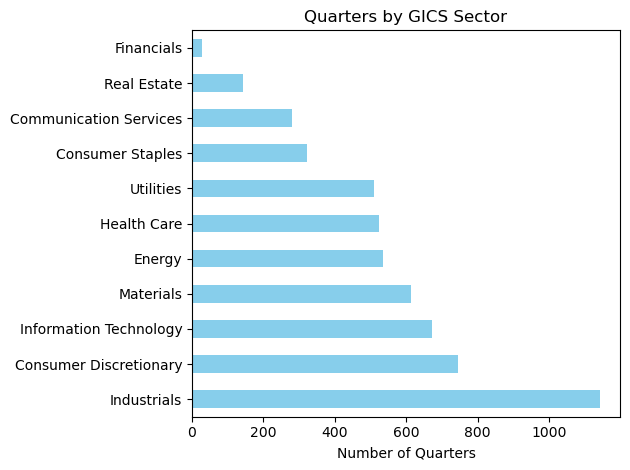

In [14]:
# Distribution of industry sectors
# variable sector
# Title: Calls in Each Industry Sector
df['Sector'].value_counts().plot(kind = 'barh', color = 'skyblue')
plt.title('Quarters by GICS Sector')
# No ytitle
plt.ylabel('')
# xtitle: Number of Quarters
plt.xlabel('Number of Quarters')
# set to tight layout
plt.tight_layout()
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_sector_distribution.png')
plt.show()

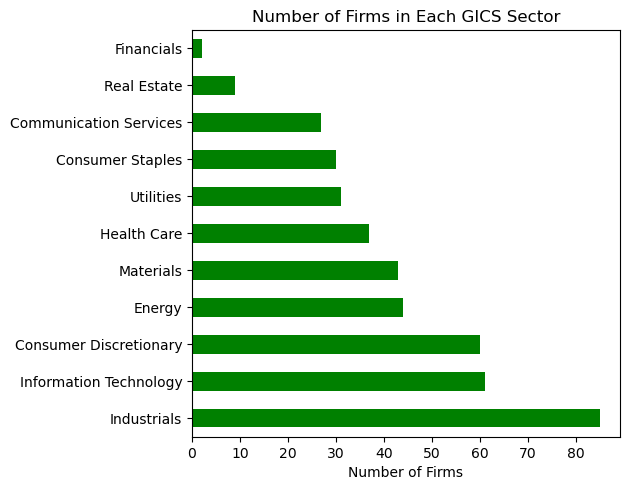

In [15]:
# Number of firms in each industry sector
# Title: Number of Firms in Each Industry Sector
# Unique ticker by sector, sort by number of firms
df.groupby('Sector')['ticker'].nunique().sort_values(ascending=False).plot(kind = 'barh', color = 'green')
# No ytitle
plt.ylabel('')
# xtitle - number of firms
plt.xlabel('Number of Firms')
# set to tight layout
plt.tight_layout()
# save version with no title
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_firms_by_sector_no_title.png')
plt.title('Number of Firms in Each GICS Sector')
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_firms_by_sector.png')
plt.show()

{'D': 0, 'C': 1, 'CC': 2, 'CCC': 3, 'B': 4, 'BB': 5, 'BBB': 6, 'A': 7, 'AA': 8, 'AAA': 9}
Rating  credit_rating_num
BBB     6.0                  1759
BB      5.0                  1457
A       7.0                  1041
B       4.0                   767
AA      8.0                   216
CCC     3.0                   127
AAA     9.0                   112
C       1.0                    16
D       0.0                     8
CC      2.0                     6
Name: count, dtype: int64


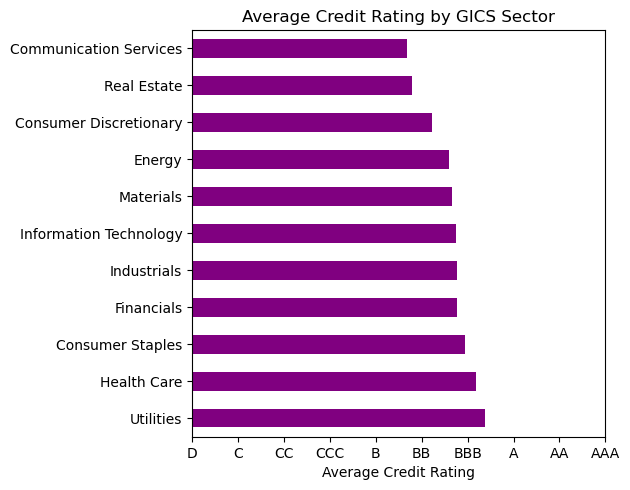

In [16]:
# Average Rating by Sector

# Numeric representation of credit rating
order_list_rating = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
# Reverse order
order_list_rating = order_list_rating[::-1]
# Create custom mapping
custom_mapping = {k: v for k, v in zip(order_list_rating, range(len(order_list_rating)))}
print(custom_mapping)

# Map credit rating to numeric
df['credit_rating_num'] = df['Rating'].map(custom_mapping).astype(float)
print(df[['Rating', 'credit_rating_num']].value_counts())

# Plot average credit rating by sector
# Title: Average Credit Rating by Sector
df.groupby('Sector')['credit_rating_num'].mean().sort_values(ascending=False).plot(kind = 'barh', color = 'purple')
# Set x axis ticks using mapping
plt.xticks(range(len(custom_mapping)), custom_mapping.keys())
# no y title
plt.ylabel('')
# xtitle: Average Credit Rating
plt.xlabel('Average Credit Rating')
# set to tight layout
plt.tight_layout()
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_average_credit_rating_by_sector_no_title.png')
plt.title('Average Credit Rating by GICS Sector')
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_average_credit_rating_by_sector.png')
plt.show()

## Quarter Counts

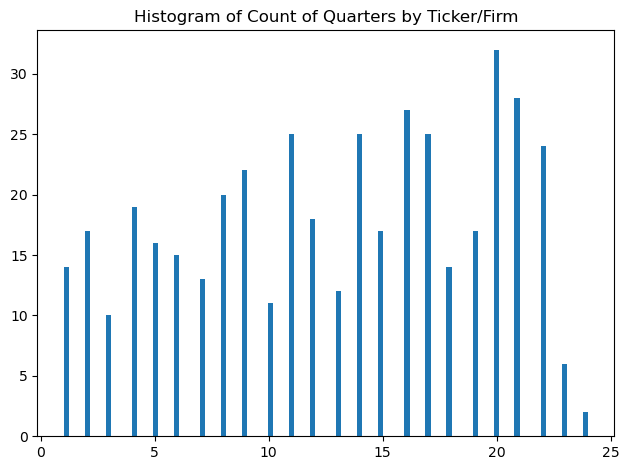

In [17]:
plt.hist(df['ticker'].value_counts(), bins = 100)
plt.title('Histogram of Count of Quarters by Ticker/Firm')
# tight layout
plt.tight_layout()
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_obs_by_ticker.png')
plt.show()

## Call Stats

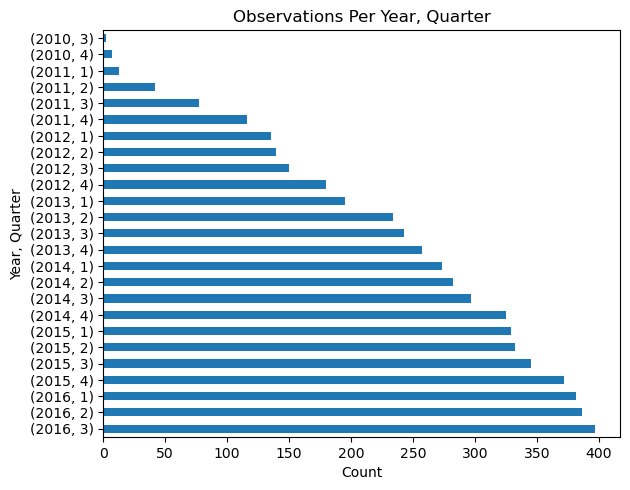

In [18]:
# Distribution of earnings_call_date year and quarter
# Create call_year and call_quarter columns after converting earnings_call_date to datetime
df['call_year'] = pd.to_datetime(df['earnings_call_date']).dt.year
df['call_quarter'] = pd.to_datetime(df['earnings_call_date']).dt.quarter
# Group by year and quarter
data_grouped = df.groupby([df.call_year, df.call_quarter]).size().sort_index(ascending=False)
# Plot horizontal bar chart
# 2010 at the top
data_grouped.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Year, Quarter')
plt.tight_layout()
# Save version with no title
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_obs_by_year_quarter_no_title.png')
plt.title('Observations Per Year, Quarter')
plt.savefig(output_folder + 'all_data_fixed_quarter_dates_obs_by_year_quarter.png')
plt.show()


See All Data - Analyze Dropout for an investigation of company dropout.

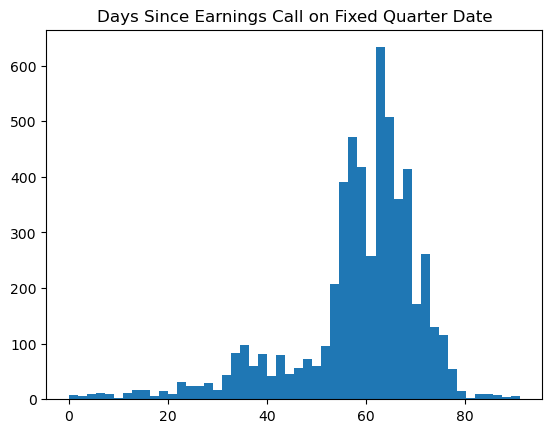

In [19]:
# Histogram of days_since_call
#credit_ratings_on_fixed_quarter_dates_with_earnings_call_date['days_since_call'].plot.hist(bins=50)
plt.hist(df['days_since_call_on_fixed_quarter'], bins=50)
plt.title('Days Since Earnings Call on Fixed Quarter Date')
plt.savefig(output_folder + 'fixed_quarter_days_since_call_all_data.png')
plt.show()

## Ratings

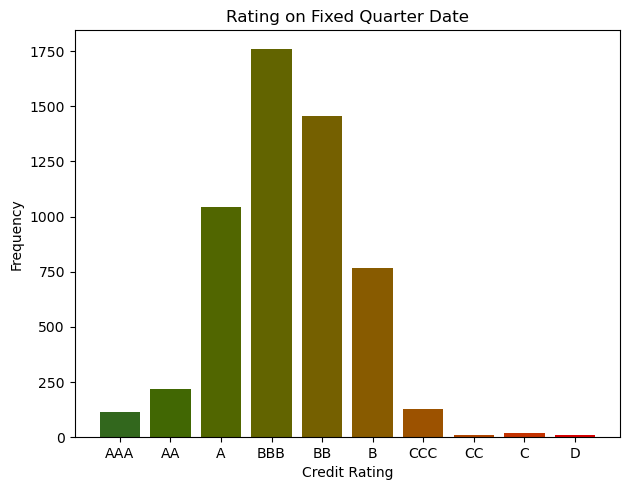

In [20]:
# Distribution of Rating and rating_on_next_earnings_call_date

# Colored with gradient and ordered

# Colors AAA through D
# Used https://colordesigner.io/gradient-generator#google_vignette
# Assign hex codes from green to red
#32671d
#416703
#516600
#626400
#756000
#885b00
#9c5200
#af4500
#c33200
#d60000
hex_code_mapper = {'AAA': '#32671d', 'AA': '#416703', 'A': '#516600', 'BBB': '#626400', 'BB': '#756000', 'B': '#885b00', 'CCC': '#9c5200', 'CC': '#af4500', 'C': '#c33200', 'D': '#d60000'}

# Ordering of bars - keys from hex_code_mapper
bar_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
# Assign values of Rating to this ordering
df['Rating'] = pd.Categorical(df['Rating'], categories=bar_order, ordered=True)

# Create plot
# Save to "../Output/Distribution of Ratings.png"
plt.bar(df['Rating'].value_counts().sort_index().index, df['Rating'].value_counts().sort_index(), color=[hex_code_mapper[i] for i in bar_order])
# ytitle - frequency
plt.ylabel('Frequency')
# xtitle - credit rating
plt.xlabel('Credit Rating')
# tight layout
plt.tight_layout()
# Save version with no title
plt.savefig(output_folder + 'Distribution of Rating Issuances_no_title.png')
plt.title('Rating on Fixed Quarter Date')
plt.savefig(output_folder + 'Distribution of Rating Issuances.png')
plt.show()

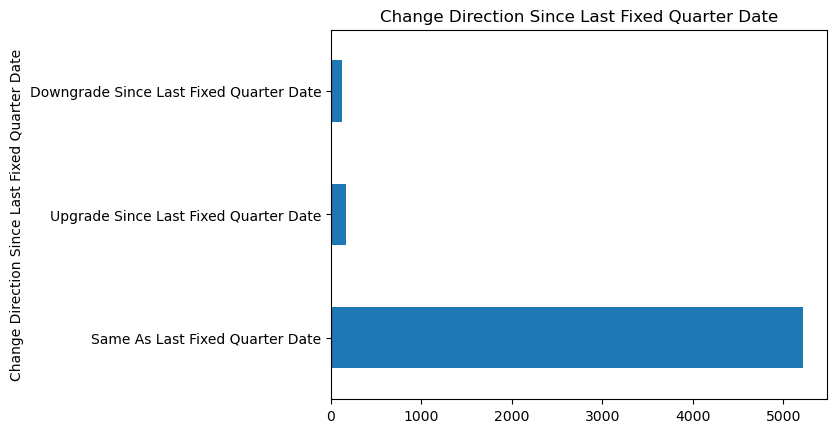

Change Direction Since Last Fixed Quarter Date
Same As Last Fixed Quarter Date            5222
Upgrade Since Last Fixed Quarter Date       167
Downgrade Since Last Fixed Quarter Date     120
Name: count, dtype: int64


C:\Users\ijyli\AppData\Local\Temp\ipykernel_20364\409833101.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df['Change_Short'].value_counts()[i], i, str(round(df['Change_Short'].value_counts()[i] / len(df['Change_Short']) * 100, 2)) + '%', va = 'center', ha='left')
C:\Users\ijyli\AppData\Local\Temp\ipykernel_20364\409833101.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df['Change_Short'].value_counts()[i], i, str(round(df['Change_Short'].value_counts()[i] / len(df['Change_Short']) * 100, 2)) + '%', va = 'center', ha='left')
C:\Users\ijyli\AppData\Local\Temp\ipykernel_20364\409833101.py:1

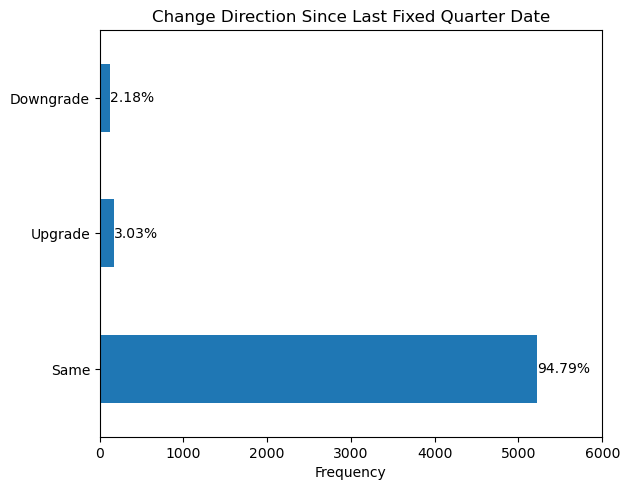

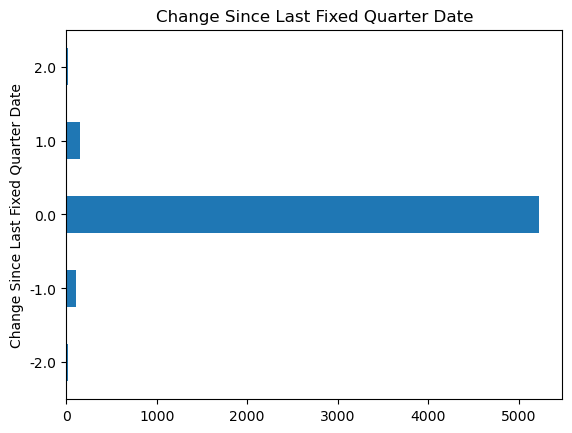

Change Since Last Fixed Quarter Date
-2.0      14
-1.0     106
 0.0    5222
 1.0     149
 2.0      18
Name: count, dtype: int64


In [21]:
df['Change Direction Since Last Fixed Quarter Date'].value_counts().plot(kind='barh')
plt.title('Change Direction Since Last Fixed Quarter Date')
plt.show()
print(df['Change Direction Since Last Fixed Quarter Date'].value_counts())

# refined version
# record 'Change Direction Since Last Fixed Quarter Date' as 'Change_Short'
df['Change_Short'] = df['Change Direction Since Last Fixed Quarter Date']
# If contains 'Same', replace with 'Same'. Downgrade with 'Downgrade', Upgrade with 'Upgrade'
df['Change_Short'] = np.where(df['Change_Short'].str.contains('Same'), 'Same', df['Change_Short'])
df['Change_Short'] = np.where(df['Change_Short'].str.contains('Downgrade'), 'Downgrade', df['Change_Short'])
df['Change_Short'] = np.where(df['Change_Short'].str.contains('Upgrade'), 'Upgrade', df['Change_Short'])
# Plot
df['Change_Short'].value_counts().plot(kind='barh')
# add percentage next to bar
for i in range(len(df['Change_Short'].value_counts())):
    plt.text(df['Change_Short'].value_counts()[i], i, str(round(df['Change_Short'].value_counts()[i] / len(df['Change_Short']) * 100, 2)) + '%', va = 'center', ha='left')
# set x axis ticks
# get size of largest count in value counts
max_count = df['Change_Short'].value_counts().max()
plt.xticks(range(0, max_count + 1000, 1000))
# no plot border
#plt.box(False)
# xtitle - frequency
plt.xlabel('Frequency')
# no ytitle
plt.ylabel('')
# tight layout
plt.tight_layout()
# save version with no title
plt.savefig(output_folder + 'Change_Short_no_title.png')
plt.title('Change Direction Since Last Fixed Quarter Date')
plt.savefig(output_folder + 'Change_Short.png')
plt.show()

df['Change Since Last Fixed Quarter Date'].value_counts().sort_index().plot(kind='barh')
plt.title('Change Since Last Fixed Quarter Date')
plt.show()
print(df['Change Since Last Fixed Quarter Date'].value_counts().sort_index())


In [22]:
# Share of ratings that are changes
print('Share of ratings that are changes:', len(df[df['Change Direction Since Last Fixed Quarter Date'] != 'Same As Last Fixed Quarter Date']) / len(df))

# Share of ratings that are not changes
share_not_changes = len(df[df['Change Direction Since Last Fixed Quarter Date'] == 'Same As Last Fixed Quarter Date']) / len(df)
# Convert to percentage and use backslashes for LaTeX
share_not_changes = '{:.2%}'.format(share_not_changes)
share_not_changes = share_not_changes.replace('%', '\%')
print(share_not_changes)
# Output using stattotex
stattotex(share_not_changes, 'shareNotChanges', output_folder + 'share_of_ratings_same_as_previous_fixed_quarter_date.tex')

Share of ratings that are changes: 0.052096569250317665
94.79\%


In [23]:
# Share of ratings that are not changes in the test dataset
share_not_changes_test = len(df[(df['Change Direction Since Last Fixed Quarter Date'] == 'Same As Last Fixed Quarter Date') & (df['train_test_80_20'] == 'test')]) / len(df[df['train_test_80_20'] == 'test'])
# Convert to percentage and use backslashes for LaTeX
share_not_changes_test = '{:.2%}'.format(share_not_changes_test)
share_not_changes_test = share_not_changes_test.replace('%', '\%')
print(share_not_changes_test)
# Output using stattotex
stattotex(share_not_changes_test, 'shareNotChangesTest', output_folder + 'share_of_ratings_same_as_previous_fixed_quarter_date.tex')

95.35\%


In [24]:
# Value counts of variable Investment_Grade
df['Investment_Grade'].value_counts()

Investment_Grade
True     3128
False    2381
Name: count, dtype: int64

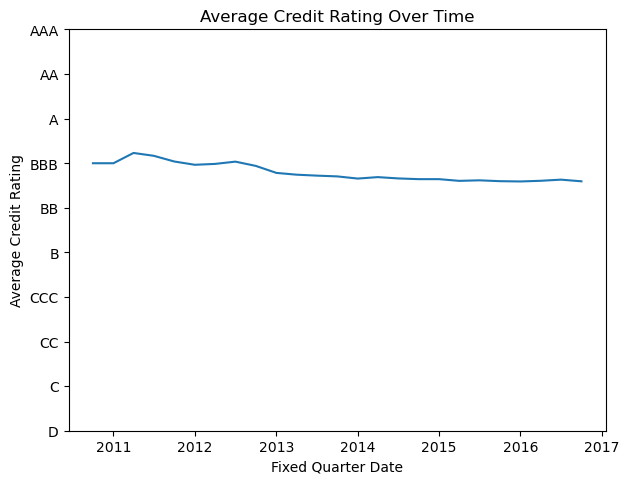

In [25]:
# Trend in rating over time
# Average of 'credit_rating_num' by fixed_quarter_date
# Plot
df.groupby('fixed_quarter_date')['credit_rating_num'].mean().plot()
plt.ylabel('Average Credit Rating')
plt.xlabel('Fixed Quarter Date')
# y axis ticks
plt.yticks(range(len(custom_mapping)), custom_mapping.keys())
plt.tight_layout()
plt.savefig(output_folder + 'average_credit_rating_over_time_no_title.png')
plt.title('Average Credit Rating Over Time')
plt.savefig(output_folder + 'average_credit_rating_over_time.png')
plt.show()

## Financial Statement Data

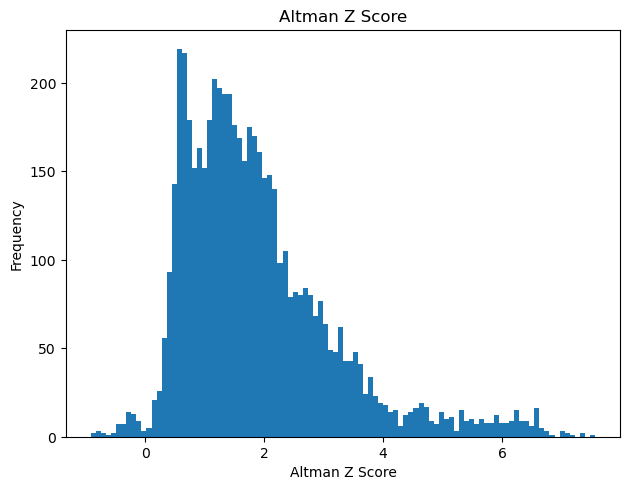

In [26]:
# Plot Altman_Z histogram
plt.hist(df['Altman_Z'], bins=100)
# xtitle - Altman Z Score
plt.xlabel('Altman Z Score')
# ytitle
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(output_folder + 'altman_z_score_all_data_no_title.png')
plt.title('Altman Z Score')
plt.savefig(output_folder + 'altman_z_score_all_data.png')
plt.show()

C:\Users\ijyli\AppData\Local\Temp\ipykernel_20364\838168288.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cl_means = df.groupby('Rating').agg({'Altman_Z': 'mean'}).reset_index()


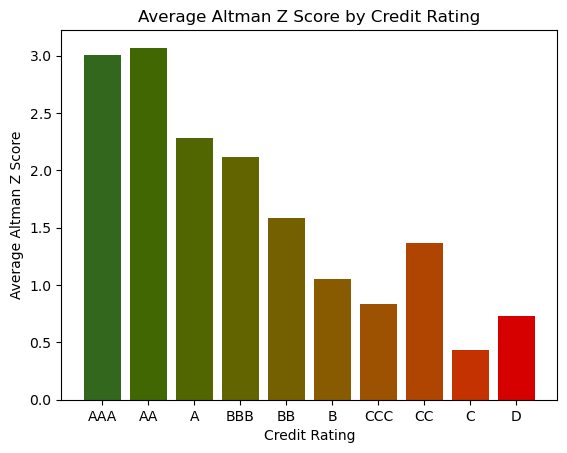

In [27]:
# Average Altmans Z by Rating
# Gradient plot

# Color coding
hex_code_mapper = {'AAA': '#32671d', 'AA': '#416703', 'A': '#516600', 'BBB': '#626400', 'BB': '#756000', 'B': '#885b00', 'CCC': '#9c5200', 'CC': '#af4500', 'C': '#c33200', 'D': '#d60000'}

# Ordering of bars - keys from hex_code_mapper
bar_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
# Assign values of Rating to this ordering
df['Rating'] = pd.Categorical(df['Rating'], categories=bar_order, ordered=True)
df = df.sort_values('Rating')

# Means of Altman_Z by credit rating
cl_means = df.groupby('Rating').agg({'Altman_Z': 'mean'}).reset_index()

# Plot
plt.bar(cl_means['Rating'], cl_means['Altman_Z'], color=cl_means['Rating'].map(hex_code_mapper))
plt.xlabel('Credit Rating')
plt.ylabel('Average Altman Z Score')
# Version with no title
plt.savefig(output_folder + 'mean_altman_Z_by_credit_rating_no_title.png')
plt.title('Average Altman Z Score by Credit Rating')
plt.savefig(output_folder + 'mean_altman_Z_by_credit_rating.png')
plt.show()

C:\Users\ijyli\AppData\Local\Temp\ipykernel_20364\2139239575.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()


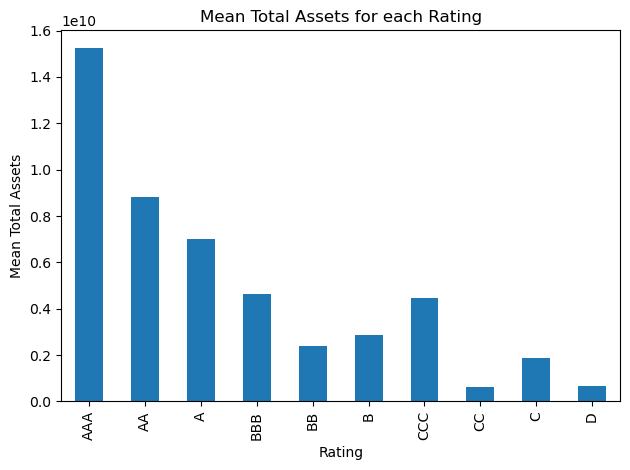

In [28]:
# Calculate the mean of "totalAssets" for each kind of "Rating"
mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Total Assets for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Total Assets')
plt.tight_layout()
plt.savefig(output_folder + 'mean_total_assets_by_rating.png')
plt.show()

C:\Users\ijyli\AppData\Local\Temp\ipykernel_20364\796684613.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()


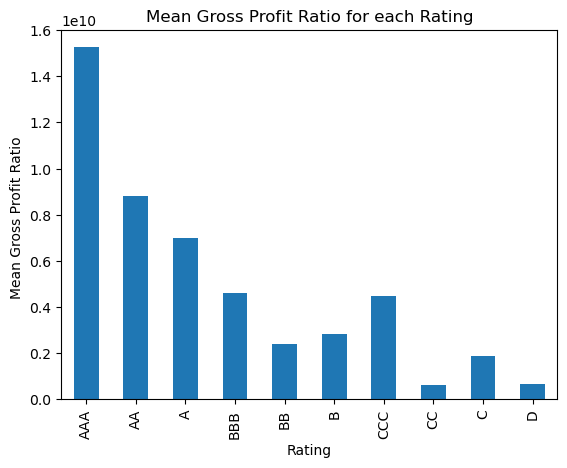

In [29]:
# Calculate the mean of "grossProfitRatio" for each kind of "Rating"
mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Gross Profit Ratio for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Gross Profit Ratio ')
plt.show()

We can see the relationship between rating and total assets; rating and gross profit ratio. High ratings like AAA will have high mean total assets and high mean gross profit ratio.

In [30]:
# Checking normalized average fianncial value to compare to the graph NN paper's table A.1
# Empty dataframe to store item, count, and percent_of_total_assets
table_a1_replication = pd.DataFrame(columns=['Item', 'Count', 'Percent_of_Total_Assets'])
# Compute average values of: totalAssets, currentLiabilities, totalLiabilities, totalEquity, retainedEarnings, currentAssets, netSales (revenue stand-in), EBIT (ebitda minus depreciation, etc),  market value of equity (commonStock + preferredStock stand-in), workingCapital, and Altman_Z
# Mean of total assets, removing missing and infinite values
total_assets_mean = df['totalAssets'].replace([np.inf, -np.inf], np.nan).dropna().mean()
# Loop over each variable
# Drop missing or infinite values
# Compute count and mean
for variable in ['totalAssets', 'totalCurrentLiabilities', 'totalLiabilities', 'totalEquity', 'retainedEarnings', 'totalCurrentAssets', 'revenue', 'EBIT', 'marketCap', 'workingCapital']:
    var_count = df[variable].replace([np.inf, -np.inf], np.nan).dropna().count()
    var_mean = df[variable].replace([np.inf, -np.inf], np.nan).dropna().mean()
    table_a1_replication = pd.concat([table_a1_replication, pd.DataFrame({'Item': variable, 'Count': var_count, 'Percent_of_Total_Assets': 100*var_mean/total_assets_mean}, index=[0])])

table_a1_replication

C:\Users\ijyli\AppData\Local\Temp\ipykernel_20364\949429418.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table_a1_replication = pd.concat([table_a1_replication, pd.DataFrame({'Item': variable, 'Count': var_count, 'Percent_of_Total_Assets': 100*var_mean/total_assets_mean}, index=[0])])


,Item,Count,Percent_of_Total_Assets
0,totalAssets,5509,100.000000
0,totalCurrentLiabilities,5509,18.034166
0,totalLiabilities,5509,62.963269
0,totalEquity,5509,31.864703
0,retainedEarnings,5509,23.270129
0,totalCurrentAssets,5509,25.249872
0,revenue,5509,17.500404
0,EBIT,5509,1.952376
0,marketCap,5509,121.832637
0,workingCapital,5509,7.215705


In [31]:
# Average value of key ratios and altman Z
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
sum_stats_ratios = df[['Ratio_A', 'Ratio_B', 'Ratio_C', 'Ratio_D', 'Ratio_E', 'Altman_Z']].describe().T
sum_stats_ratios

,count,mean,std,min,25%,50%,75%,max
Ratio_A,"5,509.00",0.02,0.02,-0.02,0.01,0.02,0.03,0.08
Ratio_B,"5,509.00",0.21,0.15,0.04,0.10,0.18,0.27,0.70
Ratio_C,"5,509.00",1.87,1.55,0.29,0.82,1.42,2.41,8.06
Ratio_D,"5,509.00",0.13,0.15,-0.13,0.02,0.10,0.23,0.57
Ratio_E,"5,509.00",0.23,0.32,-0.74,0.01,0.21,0.41,1.01
Altman_Z,"5,509.00",1.88,1.28,-0.91,0.98,1.61,2.43,7.56
